In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
#Seed function with 42 specifier produces an identical output
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the Alpaca api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# api = tradeapi.REST()
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [4]:
# Get all Asstes
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
#Check to see if API call is working
#tradeable

In [5]:
#Set the tickers
tickers = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Get 1 year's worth of historical data for AGG and SPY
df = api.get_barset(
    tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

#Check to see if code worked
df.head()

AGG                                         SPY  \
                             open      high     low    close   volume    open   
time                                                                            
2019-11-27 00:00:00-05:00  113.03  113.0700  112.96  112.995  1851568  314.61   
2019-11-29 00:00:00-05:00  113.01  113.0200  112.85  112.925  2105467  314.86   
2019-12-02 00:00:00-05:00  112.31  112.5100  112.29  112.480  5731792  314.59   
2019-12-03 00:00:00-05:00  112.80  113.1277  112.76  113.020  3547417  308.65   
2019-12-04 00:00:00-05:00  112.87  112.9500  112.68  112.800  3547118  310.70   

                                                             
                             high     low   close    volume  
time                                                         
2019-11-27 00:00:00-05:00  315.47  314.37  315.46  35080036  
2019-11-29 00:00:00-05:00  315.13  314.06  314.27  24392905  
2019-12-02 00:00:00-05:00  314.66  311.17  311.60  62704749  
2019-12-03 00:00:00-05:00  309.64  307.13  309.47  62363983  
2019-12-04 00:00:00-05:00  312.12  310.32  311.47  37810887

# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [6]:
## Calculate the daily roi for the stocks

#Organize data

# Use the `drop` function with the `level` parameter to drop extra columns in the multi-index DataFrame
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
#df.head()

# Use the `pct_change` function to calculate daily returns of `AGG` and `SPY`.
daily_returns = df.pct_change()
daily_returns.head()

,AGG,SPY
,close,close
time,,
2019-11-27 00:00:00-05:00,NaN,NaN
2019-11-29 00:00:00-05:00,-0.000619,-0.003772
2019-12-02 00:00:00-05:00,-0.003941,-0.008496
2019-12-03 00:00:00-05:00,0.004801,-0.006836
2019-12-04 00:00:00-05:00,-0.001947,0.006463


In [7]:
## Calculate volatility

# Use the `mean` function to calculate the mean of daily returns for `AGG` and `SPY`
avg_daily_return_agg = daily_returns.mean()['AGG']['close']
avg_daily_return_spy = daily_returns.mean()['SPY']['close']

# Use the `std` function to calculate the standard deviation of daily returns for `AGG` and `SPY`
std_dev_daily_return_agg = daily_returns.std()['AGG']['close']
std_dev_daily_return_spy = daily_returns.std()['SPY']['close']

In [8]:
## Save the last day's closing price
agg_last_price=df['AGG']['close'][-1]
spy_last_price=df['SPY']['close'][-1]

In [9]:
## Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252*30
#monte_carlo = pd.DataFrame()
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [10]:
## Run the Monte Carlo Simulation
for x in range(number_simulations):
    
    # Initialize the simulated prices list with the last closing price of `AGG` and `SPY`
    simulated_agg_prices = [agg_last_price]
    simulated_spy_prices = [spy_last_price]
    
    # Simulate the returns for 252 * 30 
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        #ASSUMPTION: .normal distribution
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        
        # Append the simulated price to the list
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (60% Stocks:SPY; 40% Bonds:AGG)
    weights = [0.40, 0.60]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[x] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head(10)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998834,0.998871,0.992053,1.017950,1.043116,0.975432,0.986429,1.048631,1.000340,0.978820,...,1.005026,0.968310,1.004134,1.007324,0.983058,1.009322,1.003185,1.023273,0.989850,0.976384
2,1.028620,1.012110,1.007502,0.980435,1.031014,0.971369,0.971486,1.020507,0.994704,0.967032,...,1.016426,0.972394,1.007042,1.018016,0.983899,0.961372,1.004462,1.014591,0.978898,0.989193
3,1.023056,1.007118,1.005184,0.983075,1.020542,0.943352,0.983896,0.994067,0.991630,0.995596,...,1.017269,0.946267,1.007189,1.032219,0.964571,0.968500,1.022996,0.986922,0.985615,1.003328
4,1.042624,1.013267,1.020428,0.997122,1.040797,0.952609,1.000101,0.968154,0.995815,1.010694,...,1.004011,0.957036,1.006397,1.004673,0.967626,0.962857,1.009558,0.995853,0.976167,1.003309
5,1.051005,0.983022,0.989575,1.046776,1.028467,0.944099,1.013929,0.971509,1.025770,0.988269,...,0.992008,0.964514,0.971430,0.999203,0.967136,0.942280,0.935525,1.005204,0.967986,0.992945
6,1.040037,0.960472,0.992051,1.043236,1.014564,0.961008,0.990868,0.977059,1.022143,0.976054,...,1.019113,0.976448,0.964704,1.009335,0.939707,0.934929,0.961575,0.981246,0.966946,1.010691
7,1.004060,0.958574,1.021275,1.073744,1.018335,0.968382,0.988052,0.960240,1.004264,0.986280,...,1.008346,0.990114,0.989805,1.015488,0.944589,0.936748,0.961796,1.001400,0.943662,1.033368
8,0.987499,0.990744,1.017691,1.093154,1.002794,0.974455,0.969434,0.966221,0.992689,0.996514,...,1.016374,0.994525,0.989315,1.015711,0.948139,0.941824,0.983577,1.010756,0.947616,1.024535
9,0.989478,1.002698,1.004302,1.076191,0.971663,0.946457,0.985159,0.968053,1.000690,0.993289,...,0.973505,1.009977,1.018885,1.012815,0.963182,0.948721,1.020225,1.013651,0.925559,1.023823


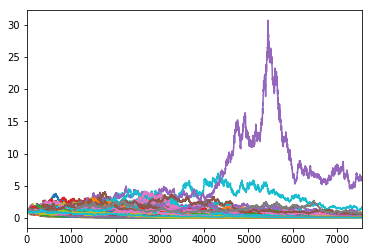

In [11]:
## Visualize the Simulation
portfolio_cumulative_returns.plot(legend=None)

In [12]:
## Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    0.023375
1    0.015189
2    0.016984
3    0.006230
4    0.016600
Name: 7560, dtype: float64

In [13]:
## Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_cumulative_return_20yrs = portfolio_cumulative_returns.iloc[-2520, :]
ending_cumulative_return_20yrs.head()

0    0.081107
1    0.061616
2    0.039395
3    0.025651
4    0.316048
Name: 5041, dtype: float64

In [14]:
## Display the 90% confidence interval for the ending returns
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05    0.001976
0.95    0.324701
Name: 7560, dtype: float64

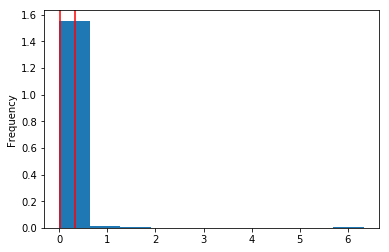

In [15]:
## Visualize the distribution of the ending returns
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [16]:
# 10th percentile
ending_cumulative_returns_10 = ending_cumulative_returns.quantile(q=[.1])

#50th percentile
ending_cumulative_returns_50 = ending_cumulative_returns.quantile(q=[.5])

#90th percentile
ending_cumulative_returns_90 = ending_cumulative_returns.quantile(q=[.9])

#Print results
ending_cumulative_returns_10, ending_cumulative_returns_50, ending_cumulative_returns_90


(0.1    0.003427
 Name: 7560, dtype: float64,
 0.5    0.026093
 Name: 7560, dtype: float64,
 0.9    0.167364
 Name: 7560, dtype: float64)

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [17]:
# Set initial investment
initial_investment = 20000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_10 = initial_investment * ending_cumulative_returns_10.iloc[0]
investment_pnl_50 = initial_investment * ending_cumulative_returns_50.iloc[0]
investment_pnl_90 = initial_investment * ending_cumulative_returns_90.iloc[0]

# Print the results
print(f"At the 10th percentile, an initial investment of $20,000 in the portfolio "
      f"over the next 30 years will be"
      f" ${investment_pnl_10}"
      
      f"At the 50th percentile, an initial investment of $20,000 in the portfolio "
      f"over the next 30 years will be"
      f" ${investment_pnl_50}"
      
      f"At the 90th percentile, an initial investment of $20,000 in the portfolio "
      f"over the next 30 years will be"
      f" ${investment_pnl_90}")
#######BUG: I think the decimal is off

At the 10th percentile, an initial investment of $20,000 in the portfolio over the next 30 years will be $68.53434307489931At the 50th percentile, an initial investment of $20,000 in the portfolio over the next 30 years will be $521.8684716455153At the 90th percentile, an initial investment of $20,000 in the portfolio over the next 30 years will be $3347.273494666596


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

**4% Withdraw Rate Analysis**
At the 10th percentile of your investable portfolio, you can anticipate having 68.53 after 30 years and your projected yearly income is $6,085. If your goal is to withdraw 4% yearly, you will not have enough to replace your income.

### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [18]:
#Rerun Monte Carlo with 30,000 initial investment

# Set initial investment
initial_investment_2 = 30000
# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_10_2 = initial_investment_2 * ending_cumulative_returns_10.iloc[0]
# Print the results
print(f"At the 10th percentile, an initial investment of $20,000 in the portfolio "
      f"over the next 30 years will be"
      f" ${investment_pnl_10_2}")

At the 10th percentile, an initial investment of $20,000 in the portfolio over the next 30 years will be $102.80151461234897


**New Monte Carlo Analysis**
A 50 percent increase in your initial investment would have no material affect on your ability to live.

### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# YOUR CODE HERE